In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, BatchNormalization, Cropping2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, SpatialDropout2D, ReLU, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import fashion_mnist
tf.keras.utils.enable_interactive_logging()
import tensorflow.keras.backend as K
from IPython.display import clear_output
from keras.saving import register_keras_serializable
import traceback
from sklearn.manifold import TSNE

# Context

A Variational Autoencoder (VAE) consists of two neural networks:

**Encoder**, which maps the input data to a latent distribution by producing:
  - A vector of means $\mu$
  - A vector of log-variances $\log\sigma^2$

**Decoder**, which reconstructs the input data from a sample $z$ drawn from the latent distribution:

$$
z \sim \mathcal{N}(\mu, \sigma^2)
$$

The sampling is done using the reparameterization trick:

$$
z = \mu + \sigma \cdot \epsilon, \quad \text{where} \quad \epsilon \sim \mathcal{N}(0, I)
$$

This trick enables backpropagation through the stochastic operation by expressing randomness as an input.

### Loss Function

The VAE is trained by minimizing a custom loss function that balances two objectives:

#### 1. Reconstruction Loss

This encourages the decoder to produce outputs similar to the original input. Typically implemented using binary cross-entropy or mean squared error. For binary data (e.g., Fashion MNIST), binary cross-entropy is common:

$$
\mathcal{L}_{\text{recon}} = \sum_i \left[ x_i \log \hat{x}_i + (1 - x_i) \log (1 - \hat{x}_i) \right]
$$

This is usually summed over all pixels and averaged across the batch.

#### 2. KL Divergence Loss

This encourages the latent distribution to be close to a standard normal distribution $\mathcal{N}(0, I)$. The KL divergence for each sample is given by:

$$
\mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum_{j=1}^{d} \left(1 + \log\sigma_j^2 - \mu_j^2 - \sigma_j^2 \right)
$$

Where:
- $d$ is the dimensionality of the latent space,
- $\mu_j$ and $\sigma_j$ are the mean and standard deviation for the $j$-th latent variable.

#### 3. Total Loss

The total loss is a weighted sum of the two components:

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{recon}} + \beta \cdot \mathcal{L}_{\text{KL}}
$$

The parameter $\beta$ controls the balance between reconstruction accuracy and latent space regularization. When $\beta = 1$, this corresponds to the standard VAE objective.

### Summary

Variational Autoencoders use reconstruction loss to enable the decoder to reproduce inputs, and KL divergence to regularize the latent space, encouraging it to follow a smooth Gaussian distribution. The reparameterization trick allows training with stochastic sampling, while the beta parameter balances reconstruction fidelity and latent space regularization.

VAEs produce a well-structured latent space where similar data points cluster closely. This supports interpolation and controlled sampling. However, their outputs tend to be somewhat blurry, as stronger regularization can reduce detail. 

Overall, VAEs learn meaningful latent representations useful for generation and interpolation, but typically generate softer images.

# Loading the dataset

In [2]:
# Loading the fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# Normalizing the data
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Preliminary data analysis

Fashion MNIST comprises 70,000 28x28 grayscale images of diverse fashion items—including shirts, dresses, sneakers, and bags, organized into ten distinct classes.

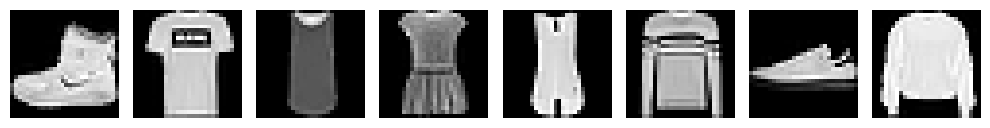

In [3]:
# Plotting a few images

fig, axes = plt.subplots(1, 8, figsize=(10, 2))

for i in range(8):
    ax = axes[i]
    ax.imshow(X_train[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Checking if the dataset is well balanced

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

print("labels of y_train")
print(dict(zip(*np.unique(y_train, return_counts=True))))
print("labels of y_test")
print(dict(zip(*np.unique(y_test, return_counts=True))))

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)
labels of y_train
{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
labels of y_test
{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


# Defining the variational autoencoder

In [5]:
X_train = np.reshape(X_train, (-1, 28, 28, 1))
X_test = np.reshape(X_test, (-1, 28, 28, 1))


### SETTING DIMENSIONS

latent_dim = 16

first_conv_filters = 8
second_conv_filters = 16
third_conv_filters = 32
fourth_conv_filters = 64
fith_conv_filters = 128

first_dense_dim = 64
second_dense_dim = 32

dropout = 0.2
spacial_dropout = 0.2


### ENCODER

# Input
encoder_input = keras.Input(shape = (28, 28, 1))
x = encoder_input
x = ZeroPadding2D(padding=2)(x) # Enlarging to 32x32

# First convolutional layer
x = Conv2D(first_conv_filters, 3, strides=2, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
# x = SpatialDropout2D(spacial_dropout)(x)

# Second convolutional layer
x = Conv2D(second_conv_filters, 3, strides=2, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
# x = SpatialDropout2D(spacial_dropout)(x)

# Third convolutional layer
x = Conv2D(third_conv_filters, 3, strides=2, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
# x = SpatialDropout2D(spacial_dropout)(x)

# Fourth convolutional layer
x = Conv2D(fourth_conv_filters, 3, strides=2, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
# x = SpatialDropout2D(spacial_dropout)(x)

# Fith convolutional layer
x = Conv2D(fith_conv_filters, 3, strides=2, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
x = SpatialDropout2D(spacial_dropout)(x)

# Flatten
x = Flatten()(x)
print(f'Encoder shape after flattening: {x.shape}')

# First dense layer
x = Dense(first_dense_dim, use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
# x = Dropout(dropout)(x)

# Second dense layer
x = Dense(second_dense_dim, use_bias=False)(x)
# x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
# x = Dropout(dropout)(x)

# Output
encoder_output = x

# Defining dense layers for mean and log variance
mean = Dense(latent_dim, name="mean")(encoder_output)
log_var = Dense(latent_dim, name="z_log_var")(encoder_output)
# mean = layers.Conv2D(latent_dim, kernel_size=1, padding="same", name="z_mean")(x) # version with only conv. layers
# log_var = layers.Conv2D(latent_dim, kernel_size=1, padding="same", name="z_log_var")(x) # version with only conv. layers


### SAMPLING AND ENCODER MODEL

@register_keras_serializable()
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z", output_shape=(4, 4, latent_dim))([mean, log_var])

# Building the encoder model
encoder = Model(encoder_input, {
                                    "z_mean": mean,
                                    "z_log_var": log_var,
                                    "z": z
                                }, name="encoder")
encoder.summary()


### DECODER

# Input
decoder_input = keras.Input(shape=(latent_dim,))
x = decoder_input

# First dense layer
x = Dense(second_dense_dim, use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
# x = Dropout(dropout)(x)

# Second dense layer
x = Dense(first_dense_dim, use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
# x = Dropout(dropout)(x)

# Third dense layer + reshaping to a convolutional layer
x = Dense(fith_conv_filters, use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
x = Dropout(dropout)(x)

x = layers.Reshape((1, 1, fith_conv_filters))(x)

# First convolutional layer
x = Conv2DTranspose(fourth_conv_filters, 3, strides=2, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
# x = SpatialDropout2D(spacial_dropout)(x)

# First convolutional layer
x = Conv2DTranspose(third_conv_filters, 3, strides=2, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
# x = SpatialDropout2D(spacial_dropout)(x)

# Second convolutional layer
x = Conv2DTranspose(second_conv_filters, 3, strides=2, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
# x = SpatialDropout2D(spacial_dropout)(x)

# Third convolutional layer
x = Conv2DTranspose(first_conv_filters, 3, strides=2, padding="same", use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
# x = SpatialDropout2D(spacial_dropout)(x)

# Flattening layer
x = Conv2DTranspose(1, 3, strides=2, padding="same", use_bias=False)(x)
# x = BatchNormalization()(x)
x = Cropping2D(cropping=((2, 2), (2, 2)))(x)
x = Activation("sigmoid")(x)

# Output
decoder_output = x

decoder = Model(decoder_input, decoder_output, name="decoder")
decoder.summary()


### VAE MODEL

@keras.utils.register_keras_serializable()
class VAE(Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def call(self, inputs):
        encoder_outputs = self.encoder(inputs)
        z_mean = encoder_outputs["z_mean"]
        z_log_var = encoder_outputs["z_log_var"]
        z = encoder_outputs["z"]

        outputs = self.decoder(z)

        reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
        reconstruction_loss = tf.reduce_sum(reconstruction_loss, axis=[1, 2])
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)

        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        # kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=[1, 2]) # For 3D latent space
        kl_loss = tf.reduce_mean(kl_loss)

        total_loss = reconstruction_loss + self.beta * kl_loss
        self.add_loss(total_loss)
        return outputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "beta": self.beta
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Encoder/decoder must be reattached manually after loading
        return cls(encoder=None, decoder=None, **config)

vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.summary()

Encoder shape after flattening: (None, 128)


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 32, 32, 1) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16, 8) │         72 │ zero_padding2d[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16, 8) │         32 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 16, 16, 8) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 16)  │      1,152 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 16)  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 8, 8, 16)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 32)  │      4,608 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 32)  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 4, 4, 32)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 2, 2, 64)  │     18,432 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 2, 2, 64)  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 128) │     73,728 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 128) │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 1, 1, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 1, 1, 128) │          0 │ leaky_re_lu_4[0]… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 110,536 (431.78 KB)

 Trainable params: 109,912 (429.34 KB)

 Non-trainable params: 624 (2.44 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 2, 2, 64)       │        73,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 4, 4, 32)       │        18,432 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 8, 8, 16)       │         4,608 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 110,120 (430.16 KB)

 Trainable params: 109,432 (427.47 KB)

 Non-trainable params: 688 (2.69 KB)

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 4, 4, 16),     │       110,536 │
│                                 │ (None, 16), (None,     │               │
│                                 │ 16))                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       110,120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,656 (861.94 KB)

 Trainable params: 219,344 (856.81 KB)

 Non-trainable params: 1,312 (5.12 KB)

# Training and evaluating the model

Loaded saved model, continuing training...
Epoch 1/2


/opt/homebrew/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:730: UserWarning: Model 'vae' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  instance.build_from_config(build_config)
/opt/homebrew/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 92 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 240.6328 - val_loss: 243.1819
Epoch 2/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 240.5119 - val_loss: 242.9052


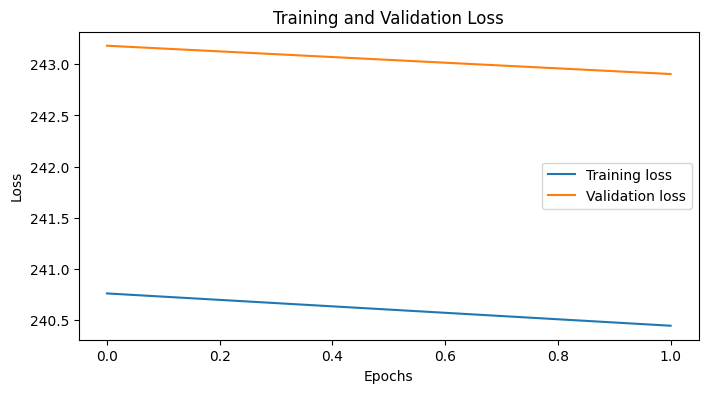

In [ ]:
train = True # Change to True to train, and to False to load trained model

try: # Try loading existing model   
    encoder = load_model("encoder_model.keras")
    decoder = load_model("decoder_model.keras")
    vae = load_model("vae_model.keras", custom_objects={"VAE": VAE})
    vae.encoder = encoder
    vae.decoder = decoder
    
    print("Loaded saved model, continuing training...")
except Exception as e:
    print("No saved model found. Starting from scratch.")
    traceback.print_exc()

vae.compile(optimizer="adam") # learning rate

if train:

    history = vae.fit(
        X_train,
        X_train,
        epochs=2, # Epochs
        batch_size=128,
        validation_data=(X_test, X_test),
        shuffle=True
    )

    encoder.save("encoder_model.keras")
    decoder.save("decoder_model.keras")
    vae.save("vae_model.keras")

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label = 'Training loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

else:

    vae = load_model("vae_model.keras", custom_objects={"VAE": VAE})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


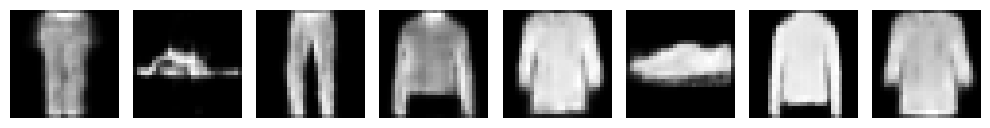

In [ ]:
def generate_images(decoder, num_images=8, latent_dim=32):

    # Sample random latent vectors
    random_latent_vectors = np.random.normal(size=(num_images, latent_dim))

    # Generate images
    generated_images = decoder.predict(random_latent_vectors)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(generated_images[i, :, :, 0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

generate_images(decoder, num_images=8, latent_dim = latent_dim)

# Latent space visualisation

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


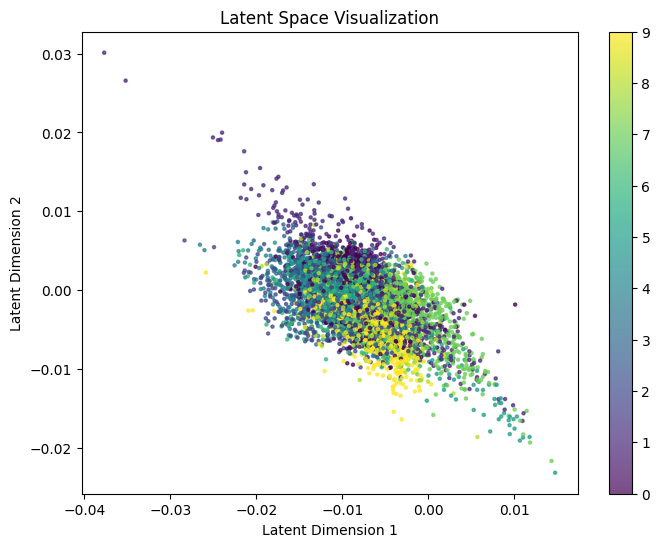

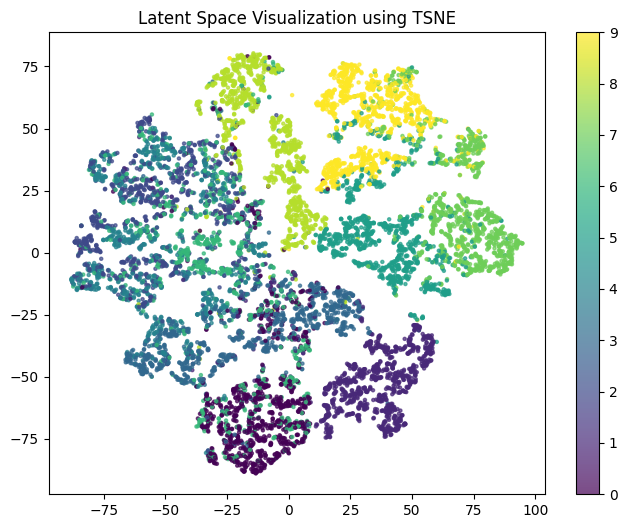

In [31]:
# Plotting the latent space
z_mean = encoder.predict(X_test)['z_mean']
plt.figure(figsize=(8, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis', s=5, alpha=0.7)
plt.colorbar()
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Visualization")
plt.show()

# Plotting the TSNE projection
tsne_embedding = TSNE(n_components=2, random_state=42).fit_transform(z_mean)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=y_test, cmap='viridis', s=5, alpha=0.7)
plt.colorbar()
plt.title("Latent Space Visualization using TSNE")
plt.show()

# Final thoughts

The generated images are generally of good quality even with a very small model, though some lack sharp detail or clearly defined categories. These may represent points in the latent space that blend features from multiple classes—such as a hybrid between a bag and a shirt. While the latent space shows promising separation between categories, its distribution still deviates somewhat from an ideal standard normal distribution.